In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rand
import pandas as pd
from math import e
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

In [3]:
grad_opinion=LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#CC0000-FFBA0A-00523A
    (0.000, (0.800, 0.000, 0.000)),
    (0.500, (1.000, 0.729, 0.039)),
    (1.000, (0.000, 0.322, 0.227))))
grad_coop= LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#D90079-FDFFFC-003C7E
    (0.000, (0.851, 0.000, 0.475)),
    (0.500, (0.992, 1.000, 0.988)),
    (1.000, (0.000, 0.235, 0.494))))

In [4]:
#G is a graph cointanining N nodes, each of which has two variables: α and s (s = 0 for defection, s = 1 for cooperation)

def networkRGG_cumulative(G,N,macrosteps,pars):
    
    vec_a_mean=[]           #empty vector to be filled with the mean of alpha at each macrostep loop
    vec_x=[]                #empty vector to be filled with the fraction of cooperators at each macrostep loop
    check=[]
    a_vec = list(nx.get_node_attributes(G, 'alpha').values())       #list of alpha of all nodes, different at every macrostep
    s_vec = list(nx.get_node_attributes(G, 'strategy').values())    #list of strategy of all nodes, different at every macrostep
 
    neighbours = [list(nx.all_neighbors(G, node)) for node in range(N)]
    
    for t in tqdm(macrosteps, desc = 'Progress Bar'):
        
        nx.set_node_attributes(G,{ n: a_vec[n] for n in range(N) },'alpha')
        nx.set_node_attributes(G,{ n: s_vec[n] for n in range(N) },'strategy')
        
        vec_a_mean = np.append(vec_a_mean, np.mean(a_vec))       #vector with mean of alpha at each macrostep
        vec_x = np.append(vec_x, np.mean(s_vec))                 #vector with fraction of cooperators at each macrostep

        s_vec=[]
        a_vec=[]
        cumulative_payoffs=[]  
        cum_x=[]
        
        #calculate the cumulative payoff and x_neighbours for all players
        for node in range(N):
            a1,s1 = G.nodes[node]['alpha'] , G.nodes[node]['strategy']
            pm1=pd.DataFrame(np.array([[-pars['p']*pars['cd']*(1-pars['e'])*(1-pars['d'])-(1-a1)*pars['cn'], -pars['p']*pars['cd']*(1-pars['e'])-(1-a1)*pars['cn']],[-pars['p']*pars['cd']*(1-pars['d']), -pars['p']*pars['cd']]]), index = [1, 0], columns=[1, 0])
            pi=0
            sum_x_neigh = 0
            
            for neighbor in neighbours[node]:
                s2 = G.nodes[neighbor]['strategy']
                pi =  pi + pm1.at[int(s1),int(s2)]
                sum_x_neigh = sum_x_neigh + s2
                
            cumulative_payoffs = np.append(cumulative_payoffs,pi)
            if len(neighbours[node])>0:
                cum_x = np.append(cum_x,sum_x_neigh/len(neighbours[node]))
            else: 
                cum_x = np.append(cum_x,s1)
        
        for pos1 in range(N):
            
            if len(neighbours[pos1])==0: 
                a1,s1 = G.nodes[pos1]['alpha'],G.nodes[pos1]['strategy'] 
                s_vec=np.append(s_vec,s1)
                a_vec=np.append(a_vec,a1)
                continue
            
            a1,s1 = G.nodes[pos1]['alpha'] , G.nodes[pos1]['strategy']  
            pos2 = rand.choice(list(neighbours[pos1]))
            s2 = G.nodes[pos2]['strategy']
            
            pi_1=cumulative_payoffs[pos1]
            pi_2=cumulative_payoffs[pos2]
            delta_pi = pi_2-pi_1              

            prob = 1/(1+e**(-beta*delta_pi))
            
            a1_new = a1 + pars['gamma']*(2*(cum_x[pos1])-1)*a1*(1-a1)
            if a1_new>=1: a1_new=0.99
            if a1_new<=0: a1_new=0.01

            if rand.random()<prob: s1_new = s2
            else: s1_new = s1
            
            a_vec=np.append(a_vec,a1_new)
            s_vec=np.append(s_vec,s1_new)
     
    return G, vec_x, vec_a_mean, np.mean(s_vec),np.mean(a_vec), cumulative_payoffs

In [5]:
beta=1
N=300
n_coop=150
radius=0.083
d=6
G = nx.random_geometric_graph(N, radius, dim=2, pos=None, p=2, seed=None)

In [52]:
beta=1
N=300
n_coop=150
radius=0.083
d=6
G1 = nx.random_geometric_graph(N, radius, dim=2, pos=None, p=2, seed=None)

In [53]:
# Parameters
pars={} 
pars['p']=0.4
pars['cd']=1
pars['e']=0.9
pars['d']=0.5
pars['cn']=0.25
pars['gamma']=1


nums = np.zeros(N) 
nums[:n_coop] = 1
np.random.shuffle(nums)
vector=np.linspace(0.01,0.99,N)

#make a copy of G
G_1 = G1.copy()

nx.set_node_attributes(G_1,{ n: vector[n] for n in range(N) },'alpha')
nx.set_node_attributes(G_1,{ n: nums[n] for n in range(N) },'strategy')

num=200
macrosteps = list(range(num))

r_1= networkRGG_cumulative(G_1,N,macrosteps,pars)

new_a_vec_1=np.transpose(r_1[0])    #final updated vector containing the alpha of each player

Progress Bar:   0%|          | 0/200 [00:00<?, ?it/s]

Progress Bar: 100%|██████████| 200/200 [00:12<00:00, 16.31it/s]


In [54]:
# Parameters
pars={} 
pars['p']=0.4
pars['cd']=1
pars['e']=0.9
pars['d']=0.5
pars['cn']=0.5
pars['gamma']=1


nums = np.zeros(N) 
nums[:n_coop] = 1
np.random.shuffle(nums)
vector=np.linspace(0.01,0.99,N)

#make a copy of G
G_2 = G1.copy()

nx.set_node_attributes(G_2,{ n: vector[n] for n in range(N) },'alpha')
nx.set_node_attributes(G_2,{ n: nums[n] for n in range(N) },'strategy')

num=200
macrosteps = list(range(num))

r_2= networkRGG_cumulative(G_2,N,macrosteps,pars)

new_a_vec_2=np.transpose(r_2[0])  

Progress Bar: 100%|██████████| 200/200 [00:12<00:00, 15.99it/s]


In [55]:
# Parameters
pars={} 
pars['p']=0.4
pars['cd']=1
pars['e']=0.9
pars['d']=0.5
pars['cn']=0.75
pars['gamma']=1


nums = np.zeros(N) 
nums[:n_coop] = 1
np.random.shuffle(nums)
vector=np.linspace(0.01,0.99,N)

#make a copy of G
G_3 = G1.copy()

nx.set_node_attributes(G_3,{ n: vector[n] for n in range(N) },'alpha')
nx.set_node_attributes(G_3,{ n: nums[n] for n in range(N) },'strategy')

num=200
macrosteps = list(range(num))

r_3= networkRGG_cumulative(G_3,N,macrosteps,pars)

new_a_vec_3=np.transpose(r_3[0]) 

Progress Bar:   0%|          | 0/200 [00:00<?, ?it/s]

Progress Bar: 100%|██████████| 200/200 [00:12<00:00, 16.08it/s]


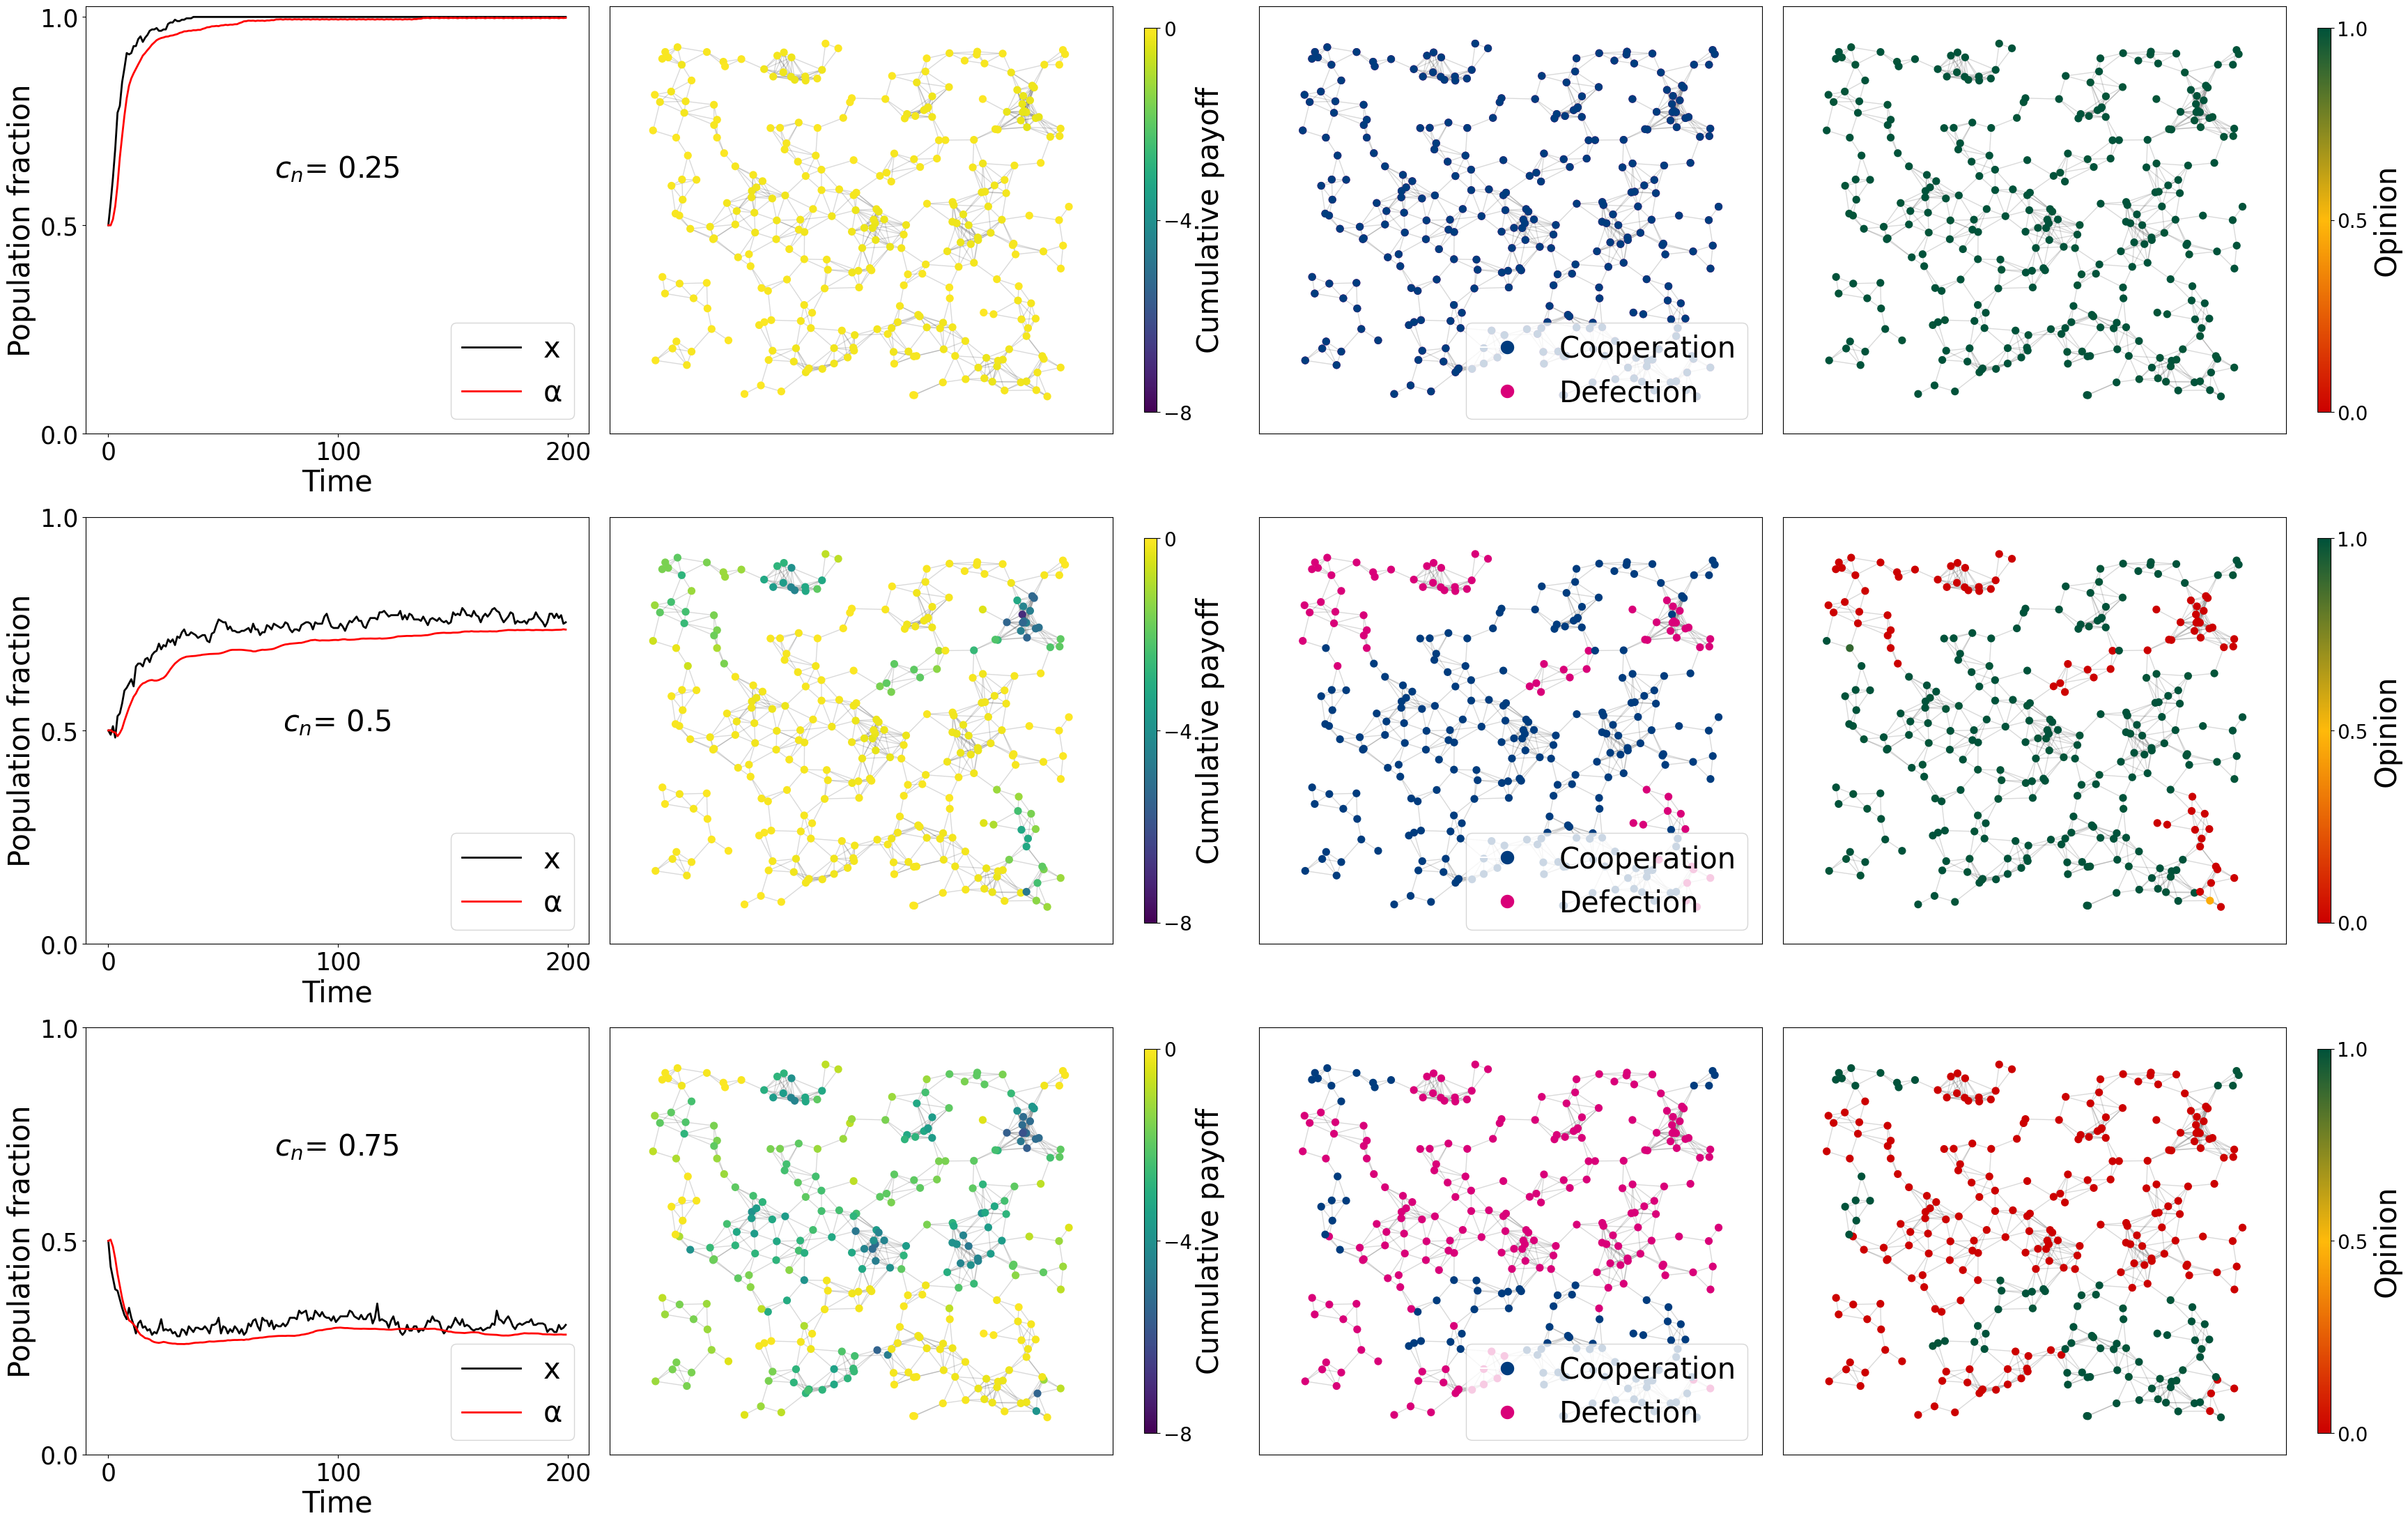

In [60]:
gs = gridspec.GridSpec(3, 4, width_ratios=[0.8, 1, 0.8, 1])  

fig = plt.figure(figsize=(35, 22))

# Create subplots with different proportions
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
ax8 = plt.subplot(gs[8])
ax9 = plt.subplot(gs[9])
ax10 = plt.subplot(gs[10])
ax11 = plt.subplot(gs[11])


## FIRST LINE



# Plot on first subplot
ax0.plot(macrosteps,r_1[1],linewidth=2,color='k')
ax0.plot(macrosteps,r_1[2],linewidth=2,color='r')
ax0.set_xticks(np.linspace(0,num,3))
ax0.set_xticklabels(np.linspace(0,num,3).astype(int),fontsize=25) 
ax0.set_yticks(np.linspace(0,1,3))
ax0.set_yticklabels(np.linspace(0,1,3).round(decimals=2),fontsize=25) 
ax0.set_xlabel('Time',fontsize=30)
ax0.set_ylabel('Population fraction',fontsize=30)
ax0.legend(['x','α'],fontsize=30,loc='lower right')
#set title inside plot ax0
ax0.text(0.5, 0.6, '$c_n$= 0.25', horizontalalignment='center', fontsize=30, transform=ax0.transAxes)


# Plot on second subplot
colors = r_1[5]
pos = nx.get_node_attributes(r_1[0], 'pos')
nodes = r_1[0].nodes()
nx.draw_networkx_edges(r_1[0], pos, alpha=0.15, ax=ax1)
nc=nx.draw_networkx_nodes(r_1[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap='viridis', ax=ax1, vmin=-8, vmax=0)
cbar=plt.colorbar(nc, ax=ax1, shrink=0.9, aspect=30)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Cumulative payoff',size=30)
cbar.set_ticks([0, -4, -8])
nc.figure.axes[1].tick_params(axis="both",labelsize=30)
#ax1.axis("off")

# Plot on third subplot
colors = list(nx.get_node_attributes(r_1[0], 'strategy').values())
nx.draw_networkx_edges(r_1[0], pos, alpha=0.15, ax=ax2)
nc=nx.draw_networkx_nodes(r_1[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=ListedColormap(['#D90079', '#003C7E'],N=2), ax=ax2)
if np.sum(colors)==len(colors): nc=nx.draw_networkx_nodes(r_1[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=ListedColormap(['#003C7E', '#D90079'],N=2), ax=ax2)
legend_elements=[Line2D([0],[0],marker='o',color='white', markersize=15,markerfacecolor="#003C7E", label='Cooperation'),Line2D([0], [0], marker='o', color='white', markersize=15,markerfacecolor="#D90079",label='Defection')]
ax2.legend(handles=legend_elements,fontsize=30,  loc='lower right')
#ax2.axis("off")

# Plot on fourth subplot
colors = list(nx.get_node_attributes(r_1[0], 'alpha').values())
nx.draw_networkx_edges(r_1[0], pos, alpha=0.15, ax=ax3)
nc=nx.draw_networkx_nodes(r_1[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=grad_opinion, ax=ax3)
cbar=plt.colorbar(nc, ax=ax3, shrink=0.9, aspect=30)
#size of ticks in colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label="Opinion",size=30)#(label=r"$\alpha_i$",size=30,weight='bold')
cbar.set_ticks([0, 0.5, 1])
nc.figure.axes[1].tick_params(axis="both",labelsize=25)
nc.set_clim(0, 1)
#ax3.axis("off")




## SECOND LINE


# Plot on first subplot
ax4.plot(macrosteps,r_2[1],linewidth=2,color='k')
ax4.plot(macrosteps,r_2[2],linewidth=2,color='r')
ax4.set_xticks(np.linspace(0,num,3))
ax4.set_xticklabels(np.linspace(0,num,3).astype(int),fontsize=25) 
ax4.set_yticks(np.linspace(0,1,3))
ax4.set_yticklabels(np.linspace(0,1,3).round(decimals=2),fontsize=25) 
ax4.set_xlabel('Time',fontsize=30)
ax4.set_ylabel('Population fraction',fontsize=30)
ax4.legend(['x','α'],fontsize=30,loc='lower right')
ax4.text(0.5, 0.5, '$c_n$= 0.5', horizontalalignment='center', fontsize=30, transform=ax4.transAxes)


# Plot on second subplot
colors = r_2[5]
pos = nx.get_node_attributes(r_2[0], 'pos')
nodes = r_2[0].nodes()
nx.draw_networkx_edges(r_2[0], pos, alpha=0.15, ax=ax5)
nc=nx.draw_networkx_nodes(r_2[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap='viridis', ax=ax5, vmin=-8, vmax=0)
cbar=plt.colorbar(nc, ax=ax5, shrink=0.9, aspect=30)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Cumulative payoff',size=30)
cbar.set_ticks([0, -4, -8])
nc.figure.axes[1].tick_params(axis="both",labelsize=30)


# Plot on third subplot
colors = list(nx.get_node_attributes(r_2[0], 'strategy').values())
nx.draw_networkx_edges(r_2[0], pos, alpha=0.15, ax=ax6)
nc=nx.draw_networkx_nodes(r_2[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=ListedColormap(['#D90079', '#003C7E'],N=2), ax=ax6)
if np.sum(colors)==len(colors): nc=nx.draw_networkx_nodes(r_2[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=ListedColormap(['#003C7E', '#D90079'],N=2), ax=ax6)
legend_elements=[Line2D([0],[0],marker='o',color='white', markersize=15,markerfacecolor="#003C7E", label='Cooperation'),Line2D([0], [0], marker='o', color='white', markersize=15,markerfacecolor="#D90079",label='Defection')]
ax6.legend(handles=legend_elements,fontsize=30,  loc='lower right')


# Plot on fourth subplot
colors = list(nx.get_node_attributes(r_2[0], 'alpha').values())
nx.draw_networkx_edges(r_2[0], pos, alpha=0.15, ax=ax7)
nc=nx.draw_networkx_nodes(r_2[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=grad_opinion, ax=ax7)
cbar=plt.colorbar(nc, ax=ax7, shrink=0.9, aspect=30)
#size of ticks in colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label="Opinion",size=30)#(label=r"$\alpha_i$",size=30,weight='bold')
cbar.set_ticks([0, 0.5, 1])
nc.figure.axes[1].tick_params(axis="both",labelsize=25)
nc.set_clim(0, 1)



## THIRD LINE

# Plot on first subplot
ax8.plot(macrosteps,r_3[1],linewidth=2,color='k')
ax8.plot(macrosteps,r_3[2],linewidth=2,color='r')
ax8.set_xticks(np.linspace(0,num,3))
ax8.set_xticklabels(np.linspace(0,num,3).astype(int),fontsize=25) 
ax8.set_yticks(np.linspace(0,1,3))
ax8.set_yticklabels(np.linspace(0,1,3).round(decimals=2),fontsize=25) 
ax8.set_xlabel('Time',fontsize=30)
ax8.set_ylabel('Population fraction',fontsize=30)
ax8.legend(['x','α'],fontsize=30,loc='lower right')
ax8.text(0.5, 0.7, '$c_n$= 0.75', horizontalalignment='center', fontsize=30, transform=ax8.transAxes)


# Plot on second subplot
colors = r_3[5]
pos = nx.get_node_attributes(r_3[0], 'pos')
nodes = r_3[0].nodes()
nx.draw_networkx_edges(r_3[0], pos, alpha=0.15, ax=ax9)
nc=nx.draw_networkx_nodes(r_3[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap='viridis', ax=ax9, vmin=-8, vmax=0)
cbar=plt.colorbar(nc, ax=ax9, shrink=0.9, aspect=30)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Cumulative payoff',size=30)
cbar.set_ticks([0, -4, -8])
nc.figure.axes[1].tick_params(axis="both",labelsize=30)
#ax1.axis("off")

# Plot on third subplot
colors = list(nx.get_node_attributes(r_3[0], 'strategy').values())
nx.draw_networkx_edges(r_3[0], pos, alpha=0.15, ax=ax10)
nc=nx.draw_networkx_nodes(r_3[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=ListedColormap(['#D90079', '#003C7E'],N=2), ax=ax10)
if np.sum(colors)==len(colors): nc=nx.draw_networkx_nodes(r_3[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=ListedColormap(['#003C7E', '#D90079'],N=2), ax=ax10)
legend_elements=[Line2D([0],[0],marker='o',color='white', markersize=15,markerfacecolor="#003C7E", label='Cooperation'),Line2D([0], [0], marker='o', color='white', markersize=15,markerfacecolor="#D90079",label='Defection')]
ax10.legend(handles=legend_elements,fontsize=30,  loc='lower right')



# Plot on fourth subplot
colors = list(nx.get_node_attributes(r_3[0], 'alpha').values())
nx.draw_networkx_edges(r_3[0], pos, alpha=0.15, ax=ax11)
nc=nx.draw_networkx_nodes(r_3[0],pos,nodelist=nodes,node_color=colors, node_size=50,cmap=grad_opinion, ax=ax11)
cbar=plt.colorbar(nc, ax=ax11, shrink=0.9, aspect=30)
#size of ticks in colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label="Opinion",size=30)#(label=r"$\alpha_i$",size=30,weight='bold')
cbar.set_ticks([0, 0.5, 1])
nc.figure.axes[1].tick_params(axis="both",labelsize=25)
nc.set_clim(0, 1)

plt.tight_layout()
plt.savefig('RGG.pdf')
plt.show()